In [1]:
import pickle
import os
import openpyxl
import io
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from global_kmeans_pp import global_clustering
import tqdm
import scipy
from scipy.spatial.distance import *
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import scipy.cluster.hierarchy as sch
from matplotlib.collections import PatchCollection, LineCollection
from sklearn.cluster import DBSCAN, KMeans
import geopandas as gpd
import shapely
from sty import fg, bg, rs

открываем БД

In [2]:
with open('resources/DARL/features.pkl', 'rb') as f:
    darl_features = pickle.load(f)
    darl_X = darl_features.to_numpy()

In [3]:
darl_X.shape

(4195, 4416)

In [4]:
with open('resources/TSAR/values.pkl', 'rb') as f:
    other_X = pickle.load(f)

In [5]:
other_X.shape

(126, 389)

открываем координаты

In [6]:
with open("resources/DARL/Координаты атласа.xlsx", "rb") as f:
    mmr = io.BytesIO(f.read())

wb = openpyxl.load_workbook(mmr, read_only=True)

ws = wb["Населённые пункты"]

darl_coords = np.array([list(map(float, cell.value.strip("()").split(", "))) for row in ws["I2":"I4196"] for cell in row])

In [7]:
with open("resources/TSAR/ВолгАтлас.xlsx", "rb") as f:
    mmr = io.BytesIO(f.read())

wb = openpyxl.load_workbook(mmr, read_only=True)

ws = wb["нп"]

other_coords = np.array([list(map(float, cell.value.split(", "))) for row in ws["G2":"G127"] for cell in row])[:, ::-1]
lect_types = [cell[0].value for cell in ws["E2":"E127"]]

villages_numbers = [str(cell.value).split(".0")[0] for row in ws["A2":"A127"] for cell in row]
villages_numbers = np.array(villages_numbers)

villages_names = np.array([cell.value for row in ws["C2":"C127"] for cell in row])
villages_states = np.array([cell.value for row in ws["D2":"D127"] for cell in row])

ws = wb["карты"]

other_features = {}
for row in ws["A2":"F111"]:
    other_features[int(row[0].value)] = int(row[-1].value)

ws = wb["матрица"]
other_features_names = np.array([cell.value for row in ws["B2":"NZ2"] for cell in row])

In [8]:
all_coords = np.vstack((darl_coords, other_coords))

In [9]:
colors = ["blue" for _ in range(len(darl_coords))] + ["red" for _ in range(len(other_coords))]

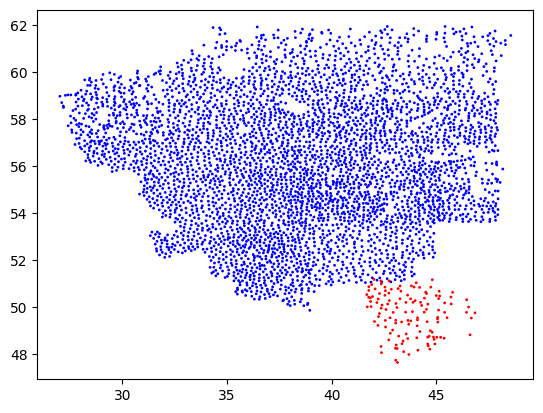

In [10]:
plt.scatter(*all_coords.T, c=colors, s=1)
plt.savefig("map.png", bbox_inches='tight', dpi=300)

открываем Волг. полигоны

In [11]:
with open('resources/TSAR/final_polygons.pkl', 'rb') as f:
    final_polygons = pickle.load(f)
with open('resources/TSAR/final_borders.pkl', 'rb') as f:
    final_borders = pickle.load(f)
with open('resources/TSAR/final_hull.pkl', 'rb') as f:
    final_hull = pickle.load(f)

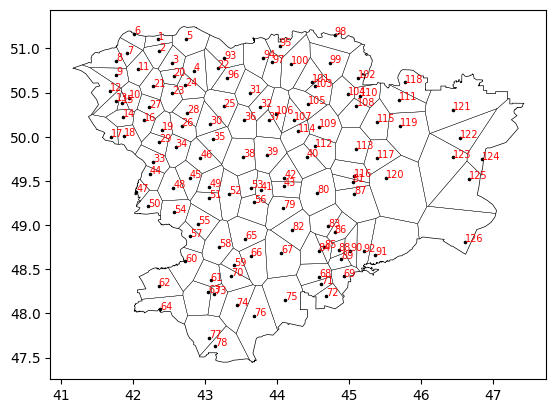

In [12]:
borders = final_borders[final_borders != None]
border_collection = LineCollection(borders, color='black', linewidths=0.25)
plt.gca().add_collection(border_collection)

plt.scatter(*other_coords.T, color="k", s=2.5)

for coords, number in zip(other_coords, villages_numbers):
    plt.text(*coords, number, c="red", fontsize=7)

plt.plot(*final_hull.exterior.xy, color='black', linewidth=0.5)

Получаем цвета из ICA

In [13]:
ica = FastICA(n_components=3, random_state=42)
ica.fit(other_X)
other_X_ica = ica.transform(other_X)

In [14]:
other_X_rgb = (other_X_ica - other_X_ica.min(axis=0)) / (other_X_ica.max(axis=0) - other_X_ica.min(axis=0))

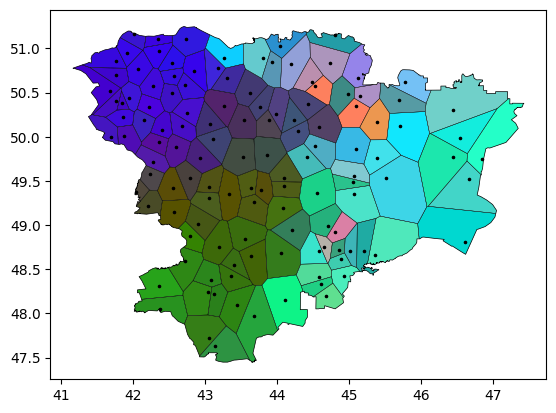

In [15]:
collection = PatchCollection(final_polygons, color=other_X_rgb, linewidths=0)
plt.gca().add_collection(collection)

borders = final_borders[final_borders != None]
border_collection = LineCollection(borders, color='black', linewidths=0.25)
plt.gca().add_collection(border_collection)

plt.scatter(*other_coords.T, color="k", s=2.5)

plt.plot(*final_hull.exterior.xy, color='black', linewidth=0.5)

кластеризируем Волг. данные

In [16]:
labels = np.empty((0, other_X.shape[0]))
cluster_centers = np.empty((0, other_X.shape[1]))
inertia = []

for n_clusters in range(10):
    model = KMeans(n_clusters=n_clusters+1, random_state=42)
    model.fit(other_X)

    labels_ = np.expand_dims(model.labels_, axis=0)
    labels = np.vstack((labels, labels_))
    
    cluster_centers_ = model.cluster_centers_
    cluster_centers = np.vstack((cluster_centers, cluster_centers_))
    
    inertia.append(model.inertia_)

labels = labels.astype(int)

In [17]:
clusters_ica = ica.transform(cluster_centers)
cluster_rgb = (clusters_ica - clusters_ica.min(axis=0)) / (clusters_ica.max(axis=0) - clusters_ica.min(axis=0))

визуализируем кластеризацию

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.21it/s]


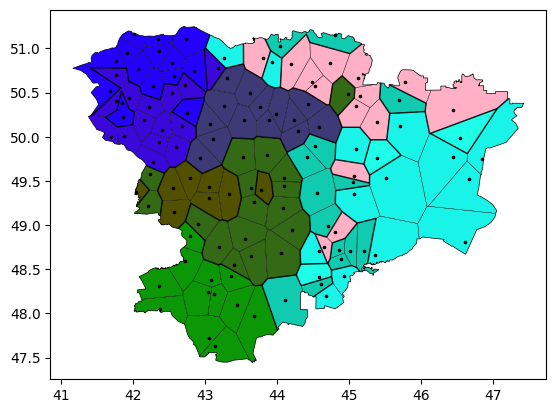

In [18]:
for i in tqdm.tqdm(range(10)):
    plt.clf()
    nth_clusters = labels[i]
    nth_rgb = cluster_rgb[sum(range(i + 1)):sum(range(i + 2))]

    nth_clusters_rgb = [nth_rgb[i] for i in nth_clusters]
    
    collection = PatchCollection(final_polygons, color=nth_clusters_rgb, linewidths=0)
    plt.gca().add_collection(collection)

    borders = final_borders[final_borders != None]
    border_collection = LineCollection(borders, color='black', linewidths=0.2)
    plt.gca().add_collection(border_collection)
    
    borders = nth_clusters[:, None] != nth_clusters
    borders = borders.reshape(-1)
    borders = final_borders[borders * (final_borders != None)]
    border_collection = LineCollection(borders, color='black', linewidths=1, alpha=0.5)
    plt.gca().add_collection(border_collection)
    
    plt.scatter(*other_coords.T, color="k", s=2.5)
    
    plt.plot(*final_hull.exterior.xy, color='black', linewidth=0.5)

    plt.savefig(f"KMeans_{i + 1}.png", bbox_inches='tight', dpi=300)

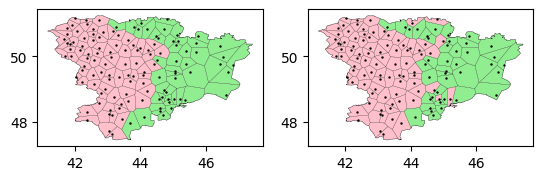

In [19]:
fig, ax = plt.subplots(1, 2)

atlas_colors = np.array(["pink" if _ == "ю.дон." else "lightgreen" for _ in lect_types])
collection = PatchCollection(final_polygons, color=atlas_colors, linewidths=0)
ax[0].add_collection(collection)

borders = final_borders[final_borders != None]
border_collection = LineCollection(borders, color='black', linewidths=0.1)
ax[0].add_collection(border_collection)

ax[0].scatter(*other_coords.T, color="k", s=0.5, edgecolor=None)
ax[0].set_aspect('equal', 'box')

ax[0].plot(*final_hull.exterior.xy, color='black', linewidth=0.25)


nth_clusters = labels[1]
kmeans_colors = np.array(["pink" if not _ else "lightgreen" for _ in nth_clusters])
collection = PatchCollection(final_polygons, color=kmeans_colors, linewidths=0)
ax[1].add_collection(collection)

borders = final_borders[final_borders != None]
border_collection = LineCollection(borders, color='black', linewidths=0.1)
ax[1].add_collection(border_collection)

ax[1].scatter(*other_coords.T, color="k", s=0.5, edgecolor=None)
ax[1].set_aspect('equal', 'box')

ax[1].plot(*final_hull.exterior.xy, color='black', linewidth=0.25)

plt.savefig("Comparison.png", bbox_inches='tight', dpi=500)

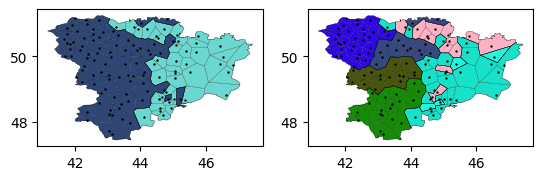

In [20]:
fig, ax = plt.subplots(1, 2)


for _, i in enumerate((1, 6)):
    nth_clusters = labels[i]
    nth_rgb = cluster_rgb[sum(range(i + 1)):sum(range(i + 2))]

    nth_clusters_rgb = [nth_rgb[i] for i in nth_clusters]

    collection = PatchCollection(final_polygons, color=nth_clusters_rgb, linewidths=0)
    ax[_].add_collection(collection)

    borders = final_borders[final_borders != None]
    border_collection = LineCollection(borders, color='black', linewidths=0.1)
    ax[_].add_collection(border_collection)

    borders = nth_clusters[:, None] != nth_clusters
    borders = borders.reshape(-1)
    borders = final_borders[borders * (final_borders != None)]
    border_collection = LineCollection(borders, color='black', linewidths=0.25)
    ax[_].add_collection(border_collection)

    ax[_].scatter(*other_coords.T, color="k", s=0.5, edgecolor=None)
    ax[_].set_aspect('equal', 'box')

    ax[_].plot(*final_hull.exterior.xy, color='black', linewidth=0.25)

plt.savefig("KMeans_2_&_7.png", bbox_inches='tight', dpi=500)

In [21]:
nth_clusters_centers = cluster_centers[1:3]
diff = atlas_colors != kmeans_colors

centers_distances = []

for n in range(len(diff)):
    dists = (
        scipy.spatial.distance.euclidean(other_X[n], nth_clusters_centers[0]),
        scipy.spatial.distance.euclidean(other_X[n], nth_clusters_centers[1])
    )
    centers_distances.append(dists)

centers_distances = np.array(centers_distances)

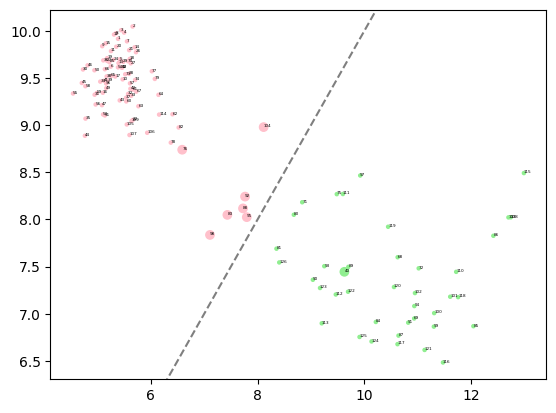

In [22]:
fig, ax = plt.subplots()

ax.scatter(*centers_distances[~diff].T, c=kmeans_colors[~diff], s=5)
ax.scatter(*centers_distances[diff].T, c=kmeans_colors[diff])

for dist_xy, number in zip(centers_distances, villages_numbers):
    ax.text(*dist_xy, number, fontsize=3)

xlim = ax.get_xlim()
ylim = ax.get_ylim()

plt.plot(*((0, 15), (0, 15)), "k--", alpha=0.5)

ax.set_xlim(xlim)
ax.set_ylim(ylim)

plt.savefig("centers_distances.png", bbox_inches='tight', dpi=500)

находим важные признаки для кластеров

In [23]:
I = 2

In [24]:
nth_clusters = labels[I-1]
nth_cluster_centers = cluster_centers[sum(range(I)):sum(range(I + 1))]

info = np.zeros((I, other_X.shape[-1]))

for n in range(I):
    wh = np.where(nth_clusters == n)
    cluster_size = len(wh[0])
    print(cluster_size)
    cluster_size = np.full(other_X.shape[-1], cluster_size) # размеры кластера
    intersection = other_X[wh].sum(axis=0) # размеры пересечений
    areal_sizes = other_X.sum(axis=0) # размеры ареалов
    union = areal_sizes + cluster_size - intersection # размеры объединений
    total_size = np.full(other_X.shape[-1], other_X.shape[0]) # размеры всего

    score = ((intersection / areal_sizes) * (intersection / cluster_size)) ** (1/2)
    info[n] = score
    
    top = sorted(enumerate(score), reverse=True, key=lambda x: x[1])
    for index, t in top[:10]:
        print(other_features_names[index], t)
    print()

86
висо́кий 0.9590807272139659
табе́, сабе́ 0.9555992196282367
упруг 0.9534883720930233
гута́рить 0.9514531821875089
бруха́ет 0.9479029932258871
волочи́ть 0.9473846207845271
отмечено к' после парных мягких согласных (Ванькя и т.п.) 0.9452802850349454
сы́ти, ра́ди 0.9425910042369908
ско́мьи 0.9415932976313764
отмечено к' после й (копейкя и т.п.) 0.9391343799048623

40
к (Ванька, копейка, с угольком, дочка и т.п.) 0.9271050693011065
высо́кий 0.9035079029052513
борони́ть, боронова́ть 0.8680370799067418
ска́мьи 0.8664763412811686
бре́зговать 0.8660254037844386
око́сиво 0.8406055240472927
кузне́ц 0.8390607775994223
ба́ра-ба́ра и другие подзывные сходного звукового комплекса 0.8385254915624212
ва́рим 0.8366600265340756
мя́чик 0.8366600265340756



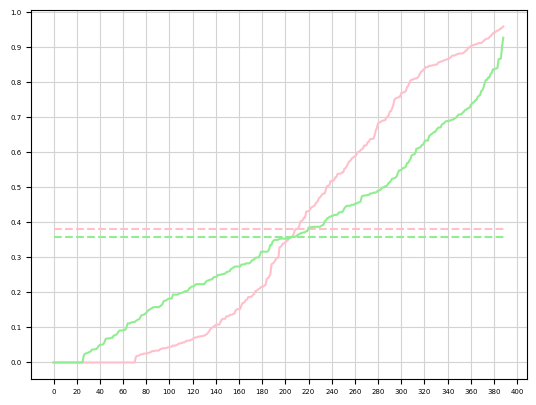

In [25]:
plt.plot(sorted(info[0]), color="pink")
plt.plot(*((0, len(info[0])), (info[0].mean(), info[0].mean())), "--" , color="pink")

plt.plot(sorted(info[1]), color="lightgreen")
plt.plot(*((0, len(info[1])), (info[1].mean(), info[1].mean())), "--" , color="lightgreen")

plt.xticks(np.arange(0, 420, 20))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.tick_params(axis='both', labelsize=5)

plt.grid(c="lightgrey")

plt.savefig("east vs west.png", bbox_inches='tight', dpi=300)

In [26]:
for n, d in enumerate(diff):
    if d:
        village_vector = other_X[n]
        village_cluster = nth_clusters[n]
        cluster_info = info[village_cluster]
        other_info = info[~village_cluster]
        print(villages_numbers[n], village_cluster)

        
        cluster_sort = np.argsort(cluster_info)[::-1]
        village_vector_sort = village_vector[cluster_sort]

        presented = other_features_names[cluster_sort][village_vector_sort == 1]
        print(presented[:25])

        
        other_sort = np.argsort(other_info)[::-1]
        village_vector_sort = village_vector[other_sort]

        not_presented = other_features_names[other_sort][village_vector_sort == 0]
        print(not_presented[:25])
        print()

40 1
['к (Ванька, копейка, с угольком, дочка и т.п.)' 'высо́кий' 'бре́зговать'
 'око́сиво' 'мя́чик' 'изба' 'пря́тать' 'сковоро́дник' 'ковш'
 'разгова́ривать' 'пету́х' 'нести́' 'дыра'
 'миня́, тибя́, сибя́ или меня́ и т. д.' 'е́ (мое́й, твое́й, свое́й)'
 '-т (сиди́т, иду́т и т.п.)' 'бежы́' 'племя́нник' 'тот, та, те' 'ухва́т'
 'итти́, ити́' 'верхний брус дверной рамы' 'квашня́' "иш'ш'о́" 'гнёт']
['висо́кий' 'табе́, сабе́' 'гута́рить' 'волочи́ть'
 "отмечено к' после парных мягких согласных (Ванькя и т.п.)"
 'сы́ти, ра́ди' "отмечено к' после й (копейкя и т.п.)"
 "-с'с'и (бои́сси и т.п.)" 'ме́чик' 'свекрЫ' 'хорони́ть'
 '-у́йа (молоду́я, большу́я и т.п.)' "-с'и (умы́лси и т.п.)"
 'двуми́, трюми́' 'бурче́ть' 'при отцу́' 'ити́ть' 'э́нтот, э́нта, э́нти'
 'диря' 'ассимилятивно-диссимилятивное яканье кидусовского подтипа'
 '-ей (пе́чей, гря́зей и т.п.)' 'рога́ч' 'внук' 'ди́верь' 'косьё']

76 0
['висо́кий' 'табе́, сабе́' 'упруг' 'гута́рить' 'бруха́ет' 'волочи́ть'
 "отмечено к' после парных мягких 

In [27]:
I = 7

In [28]:
nth_clusters = labels[I-1]
nth_cluster_centers = cluster_centers[sum(range(I)):sum(range(I + 1))]

nth_rgb = cluster_rgb[sum(range(I)):sum(range(I + 1))]

info = np.zeros((I, other_X.shape[-1]))

for n in range(I):
    wh = np.where(nth_clusters == n)
    cluster_size = len(wh[0])

    this_rgb = (nth_rgb[n] * 255).astype(int)
    string = [bg(*this_rgb.tolist())]
    if this_rgb.mean() < 127:
        string.append(fg(255, 255, 255))
    string.append(str(cluster_size))
    
    cluster_size = np.full(other_X.shape[-1], cluster_size) # размеры кластера
    intersection = other_X[wh].sum(axis=0) # размеры пересечений
    areal_sizes = other_X.sum(axis=0) # размеры ареалов
    union = areal_sizes + cluster_size - intersection # размеры объединений
    total_size = np.full(other_X.shape[-1], other_X.shape[0]) # размеры всего

    score = ((intersection / areal_sizes) * (intersection / cluster_size)) ** (1/2)
    info[n] = score
    
    top = sorted(enumerate(score), reverse=True, key=lambda x: x[1])
    for index, t in top[:10]:
        string.append(f"{other_features_names[index]} {t}")
    string.append(fg.rs)
    string.append(bg.rs)

    print("\n".join(string))



17
занаве́ска 0.8091547798786778
курча́та 0.6377481392176932
ча́пля 0.6060432152628562
рубе́ль 0.598089167121675
цара́й 0.5825517280354631
крестьянский дом (нейтральное качество, стилистически нейтральное слово) 0.5820855000871992
дом 0.570781792985393
сеть для ловли птиц 0.5653714169178546
баклажа́ны, баклашки́ 0.5508226327552436
бо́кчи 0.5178087050187163



4
ботва́ 0.75
свекру́ха 0.5303300858899106
упой 0.5
землянка 0.408248290463863
тот, та, те 0.4
иканье 0.39528470752104744
ва́рим 0.3779644730092272
наме́дни 0.3779644730092272
отмечены другие подзывные 0.3535533905932738
пли́ты 0.3535533905932738




31
ца́пельник 0.9692233691951198
клев 0.9153348228041135
ишто́ 0.9107651110783744
мяня́, тябя́, сябя́ 0.8986914687663685
пекулёк, пеку́лька, пеку́шка, пекушо́к 0.8890008890013334
упле́тни 0.8858078930362389
пата́шки, бата́шки 0.842423539174232
коньцы́ 0.7777137710478189
огурьцы́ 0.7677001739647403
сеть для ловли зайцев, волков 0.7581425055034352



14
г/к (гусь, дуга́, друк и т.п.) 

Соотносим ДАРЯ и Волг. атлас

In [31]:
def mf_index(map_, feature):
    s = 0
    for k, v in other_features.items():
        if k < map_:
            s += v
    s += (feature - 1)
    return s

In [32]:
cropped_darl_X = []
modified_other_X = []

with open("DARL_TSAR.txt", "r") as file:
    for l in file.readlines():
        if l.startswith("["):
            darl_instr, volg_instr = l.rstrip("\n").split(" = ")
            
            darl_found = re.finditer(r"\[\d*\]", darl_instr)
            
            prev = 0
            darl_form = ""
            
            for match in darl_found:
                l_pos, r_pos = match.span()
                darl_form += darl_instr[prev:l_pos]
                darl_form += f"darl_X[:, {int(darl_instr[l_pos:r_pos].strip("[]")) - 1}].astype(bool)"
                prev = r_pos
            darl_form += darl_instr[prev:]

            darl_col = eval(f"({darl_form}).astype(int)")
            cropped_darl_X.append(darl_col)
            

            volg_found = re.finditer(r"\[\d*, \d*\]", volg_instr)

            prev = 0
            volg_form = ""
            
            for match in volg_found:
                l_pos, r_pos = match.span()
                volg_form += volg_instr[prev:l_pos]
                m_, f_ = map(int, volg_instr[l_pos:r_pos].strip("[]").split(", "))
                to_add = f"other_X[:, {mf_index(m_, f_)}]"
                try:
                    if volg_instr[r_pos + 1] != "=":
                        to_add += ".astype(bool)"
                except IndexError:
                    to_add += ".astype(bool)"
                volg_form += to_add
                prev = r_pos
            volg_form += volg_instr[prev:]

            volg_col = eval(f"({volg_form}).astype('int')")
            modified_other_X.append(volg_col)

cropped_darl_X = np.stack(cropped_darl_X, axis=1)
modified_other_X = np.stack(modified_other_X, axis=1)

In [33]:
print(cropped_darl_X.shape)
print(modified_other_X.shape)

(4195, 226)
(126, 226)


In [34]:
XX = np.vstack((cropped_darl_X, modified_other_X))

Сравним кластеры

In [35]:
mean_frst = modified_other_X[nth_clusters == 4].mean(axis=0)
mean_scnd = modified_other_X[nth_clusters == 1].mean(axis=0)

In [36]:
diff_mean = abs(mean_frst - mean_scnd)

In [37]:
most_different_indices = np.argsort(diff_mean)[::-1]

In [38]:
for d_mean, md_ in zip(diff_mean[most_different_indices], most_different_indices):
    print(d_mean, "\t", md_)

0.75 	 175
0.6538461538461539 	 218
0.6346153846153846 	 172
0.6153846153846154 	 29
0.5961538461538461 	 11
0.5769230769230769 	 106
0.5769230769230769 	 107
0.5 	 85
0.4807692307692308 	 170
0.4807692307692308 	 169
0.4807692307692308 	 67
0.46153846153846156 	 17
0.42307692307692313 	 211
0.42307692307692313 	 42
0.4230769230769231 	 84
0.3846153846153846 	 46
0.3846153846153846 	 130
0.3846153846153846 	 178
0.36538461538461536 	 183
0.36538461538461536 	 81
0.36538461538461536 	 102
0.34615384615384615 	 23
0.34615384615384615 	 45
0.34615384615384615 	 44
0.34615384615384615 	 163
0.3269230769230769 	 64
0.3269230769230769 	 88
0.3076923076923077 	 105
0.3076923076923077 	 120
0.3076923076923077 	 43
0.3076923076923077 	 137
0.3076923076923077 	 108
0.3076923076923077 	 83
0.3076923076923077 	 109
0.3076923076923077 	 79
0.3076923076923077 	 168
0.3076923076923077 	 22
0.2692307692307693 	 104
0.2692307692307692 	 210
0.2692307692307692 	 8
0.2692307692307692 	 176
0.269230769230

In [39]:
mean_index = 217

print(mean_frst[mean_index])
print(mean_scnd[mean_index])

0.5
0.75


разбиваем соотнесение на разделы

In [47]:
morph_XX = XX[:, :64]

In [48]:
morph_distances_matrix = pdist(morph_XX, metric='euclidean')
morph_square = squareform(morph_distances_matrix)
morph_square = (morph_square - morph_square.min()) / (morph_square.max() - morph_square.min())

In [49]:
phon_XX = XX[:, 64:118]

In [50]:
phon_distances_matrix = pdist(phon_XX, metric='euclidean')
phon_square = squareform(phon_distances_matrix)
phon_square = (phon_square - phon_square.min()) / (phon_square.max() - phon_square.min())

In [51]:
lex_XX = XX[:, 118:]

In [52]:
lex_distances_matrix = pdist(lex_XX, metric='euclidean')
lex_square = squareform(lex_distances_matrix)
lex_square = (lex_square - lex_square.min()) / (lex_square.max() - lex_square.min())

In [53]:
fields_square = np.stack((phon_square, morph_square, lex_square), axis=2)

In [54]:
common_distances_matrix = pdist(XX, metric='euclidean')
common_square = squareform(common_distances_matrix)

получаем полигоны для построения карт

In [55]:
provinces_1897 = gpd.read_file("provinces_1897.gpkg")

In [56]:
geoms_1897 = []

for prov in tqdm.tqdm(provinces_1897['geometry']):
    for geom in prov.geoms:
        geoms_1897.append(geom)

100%|██████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 4292.11it/s]


находим и отображаем близости говоров ДАРЯ к центрам кластеров

In [57]:
plt.rcParams['axes.facecolor'] = '#dddddd'

In [58]:
I = 2

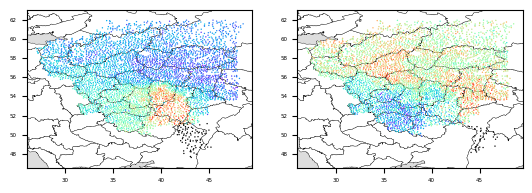

In [59]:
nth_clusters = labels[I-1]
nth_cluster_centers = cluster_centers[sum(range(I)):sum(range(I + 1))]

info = np.zeros((I, other_X.shape[-1]))

fig, ax = plt.subplots(1, 2)

for n in range(I):

    modified_cluster_center = modified_other_X[nth_clusters == n].mean(axis=0)
    distances = np.array([scipy.spatial.distance.euclidean(cropped_darl_vector, modified_cluster_center) for cropped_darl_vector in cropped_darl_X])
    distances = (distances - distances.min()) / (distances.max() - distances.min())
    
    for geom in geoms_1897:
        ax[n].fill(*geom.exterior.xy, "white", linewidth=0.25, edgecolor="black")

    ax[n].scatter(*darl_coords.T, c=distances, s=1, marker='o', cmap='rainbow_r', edgecolors='none')
    
    ax[n].scatter(*other_coords[nth_clusters == n].T, c="black", s=1, marker='o', edgecolors='none')

    ax[n].set_xlim([26, 49.5])
    ax[n].set_ylim([46.5, 63])

    
    ax[n].tick_params(axis='both', labelsize=4)
    ax[n].set_aspect('equal')
    
plt.savefig(f"proximities {I}.png", bbox_inches='tight', dpi=500)

In [60]:
I = 7

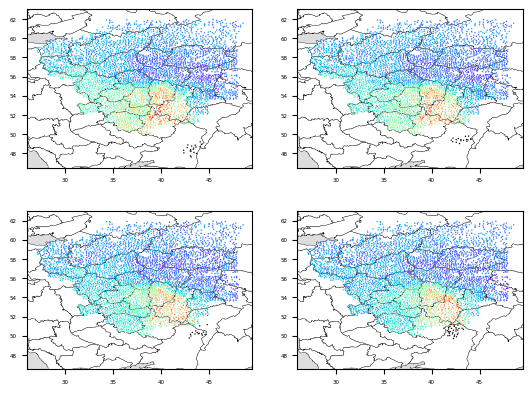

In [61]:
nth_clusters = labels[I-1]
nth_cluster_centers = cluster_centers[sum(range(I)):sum(range(I + 1))]

info = np.zeros((I, other_X.shape[-1]))

fig, ax = plt.subplots(2, 2)

for _, n in enumerate((6, 0, 5, 2)):
    ax_x, ax_y = divmod(_, 2)

    modified_cluster_center = modified_other_X[nth_clusters == n].mean(axis=0)
    distances = np.array([scipy.spatial.distance.euclidean(cropped_darl_vector, modified_cluster_center) for cropped_darl_vector in cropped_darl_X])
    distances = (distances - distances.min()) / (distances.max() - distances.min())
    
    for geom in geoms_1897:
        ax[ax_x, ax_y].fill(*geom.exterior.xy, "white", linewidth=0.25, edgecolor="black")

    ax[ax_x, ax_y].scatter(*darl_coords.T, c=distances, s=1, marker='o', cmap='rainbow_r', edgecolors='none')
    
    ax[ax_x, ax_y].scatter(*other_coords[nth_clusters == n].T, c="black", s=1, marker='o', edgecolors='none')

    ax[ax_x, ax_y].set_xlim([26, 49.5])
    ax[ax_x, ax_y].set_ylim([46.5, 63])

    
    ax[ax_x, ax_y].tick_params(axis='both', labelsize=4)
    ax[ax_x, ax_y].set_aspect('equal')
    
plt.savefig(f"proximities {I}.png", bbox_inches='tight', dpi=500)

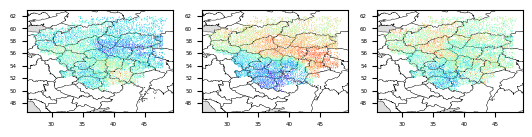

In [62]:
nth_clusters = labels[I-1]
nth_cluster_centers = cluster_centers[sum(range(I)):sum(range(I + 1))]

info = np.zeros((I, other_X.shape[-1]))

fig, ax = plt.subplots(1, 3)

for _, n in enumerate((4, 3, 1)):
    modified_cluster_center = modified_other_X[nth_clusters == n].mean(axis=0)
    distances = np.array([scipy.spatial.distance.euclidean(cropped_darl_vector, modified_cluster_center) for cropped_darl_vector in cropped_darl_X])
    distances = (distances - distances.min()) / (distances.max() - distances.min())
    
    for geom in geoms_1897:
        ax[_].fill(*geom.exterior.xy, "white", linewidth=0.25, edgecolor="black")

    ax[_].scatter(*darl_coords.T, c=distances, s=0.5, marker='o', cmap='rainbow_r', edgecolors='none')
    
    ax[_].scatter(*other_coords[nth_clusters == n].T, c="black", s=0.5, marker='o', edgecolors='none')

    ax[_].set_xlim([26, 49.5])
    ax[_].set_ylim([46.5, 63])

    
    ax[_].tick_params(axis='both', labelsize=4)
    ax[_].set_aspect('equal')
    
plt.savefig(f"proximities {I}.png", bbox_inches='tight', dpi=500)

находим и отображаем близости говоров ДАРЯ к конкретным н/п

In [64]:
i = - 1 + 93

93 Калиновский
[52.76252327 41.09167244]


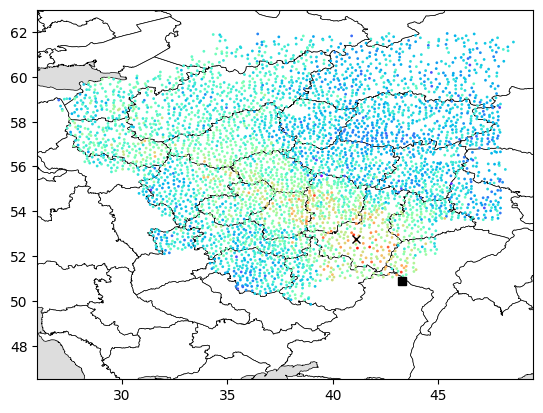

In [65]:
for geom in geoms_1897:
    plt.fill(*geom.exterior.xy, "white", linewidth=0.5, edgecolor="black")

distances = common_square[len(darl_coords) + i][:len(darl_coords)]
distances = (distances - distances.min()) / (distances.max() - distances.min())
# plt.scatter(*darl_coords.T, c=distances, s=25*(1-distances), marker='o', cmap='inferno_r', edgecolors='none', alpha=0.5)
plt.scatter(*darl_coords.T, c=distances, s=4, marker='o', cmap='rainbow_r', edgecolors='none')

plt.plot(*other_coords[i], "ks")
print(villages_numbers[i], villages_names[i])

# dot = np.array([58.59861762699931, 49.61645352544154])[::-1]
# plt.plot(*dot, "kx")

new_dot = darl_coords[np.argmin(distances)]
print(new_dot[::-1])
plt.plot(*new_dot, "kx")

plt.xlim(26, 49.5)
plt.ylim(46.5, 63)

plt.savefig(f"{villages_numbers[i]} {villages_names[i]}.png", bbox_inches='tight', dpi=300)

# i += 1

93 Калиновский


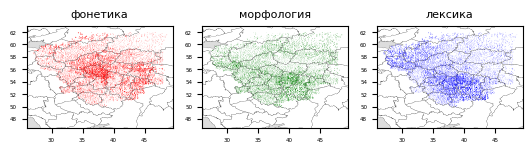

In [67]:
fig, ax = plt.subplots(1, 3)

for geom in geoms_1897:
    ax[0].fill(*geom.exterior.xy, "white", linewidth=0.1, edgecolor="black")
    ax[1].fill(*geom.exterior.xy, "white", linewidth=0.1, edgecolor="black")
    ax[2].fill(*geom.exterior.xy, "white", linewidth=0.1, edgecolor="black")

distances = fields_square[len(darl_coords) + i][:len(darl_coords)]

for ic, (color, title) in enumerate(zip(
    ["red", "green", "blue"],
    ["фонетика", "морфология", "лексика"]
)):
    norm_distances = distances[:, ic]
    norm_distances = (norm_distances - norm_distances.min()) / (norm_distances.max() - norm_distances.min())
    ax[ic].scatter(*darl_coords.T, c=color, s=(1-norm_distances), marker='o', edgecolors='none', alpha=(1-norm_distances))

    ax[ic].set_xlim([26, 49.5])
    ax[ic].set_ylim([46.5, 63])

    ax[ic].tick_params(axis='both', labelsize=4)

    ax[ic].set_title(title, fontsize=8)
    
    ax[ic].set_aspect('equal')

print(villages_numbers[i], villages_names[i])

plt.savefig(f"{villages_numbers[i]} {villages_names[i]} domains.png", bbox_inches='tight', dpi=500)